In [1]:
from dataset import ClsDataset
from torch.utils.data import DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt

data_dir = './validation_05/resize224'
data_set = ClsDataset(data_dir)
data_loader = DataLoader(
    data_set,
    batch_size=15,
    shuffle=True,
)

In [2]:
import os
lst = sorted(os.listdir(data_dir))
lst

['05011001',
 '05011002',
 '05011004',
 '05011008',
 '05011010',
 '05011011',
 '05011012',
 '05012001',
 '05012002',
 '05012003',
 '05012004',
 '05012005',
 '05013001']

Loaded pretrained weights for efficientnet-b0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([1, 13])
tensor([3], device='cuda:0')
torch.Size([1, 13])
tensor([0], device='cuda:0')
torch.Size([1, 13])
tensor([2], device='cuda:0')
torch.Size([1, 13])
tensor([12], device='cuda:0')
torch.Size([1, 13])
tensor([6], device='cuda:0')
torch.Size([1, 13])
tensor([7], device='cuda:0')
torch.Size([1, 13])
tensor([5], device='cuda:0')
torch.Size([1, 13])
tensor([4], device='cuda:0')
torch.Size([1, 13])
tensor([7], device='cuda:0')
torch.Size([1, 13])
tensor([2], device='cuda:0')
torch.Size([1, 13])
tensor([6], device='cuda:0')
torch.Size([1, 13])
tensor([10], device='cuda:0')
torch.Size([1, 13])
tensor([2], device='cuda:0')
torch.Size([1, 13])
tensor([10], device='cuda:0')
torch.Size([1, 13])
tensor([0], device='cuda:0')


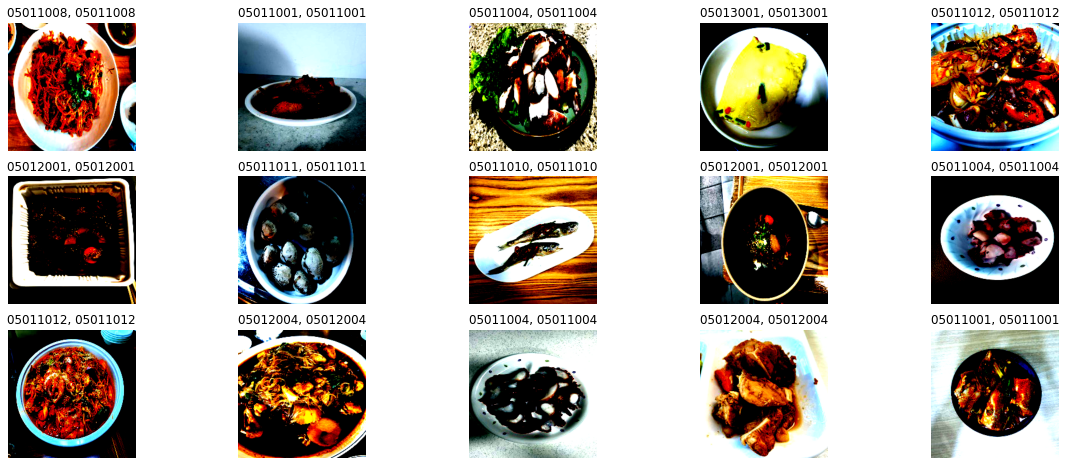

In [3]:
from model import ClsModel
import os
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
m = torch.nn.Sigmoid()

model = ClsModel(num_classes=len(lst))

model_path = './model/resize224_e30/best.pth'
model.load_state_dict(torch.load(model_path, map_location=device))  #모델 불러오기

model = model.to(device)
model.eval()

d = next(iter(data_loader))                      #loader에서 배치사이즈 만큼 random하게 뽑아온다.
fig, ax = plt.subplots(3, 5, figsize=(20,8))
ax = ax.flatten()

with torch.no_grad():

    for i in range(15):
        data = d[0][i]
        label = d[1][i]
        
        ax[i].imshow(data.permute(1,2,0))   #plt에 맞춰서 permute
        
        data = data.to(device)

        out = model(data.unsqueeze(0))      #기존 3차원에서 배치까지 포함된 4차원에 맞추기 위해 unsqueeze
        print(out.shape)

        preds = torch.argmax(out, dim=-1)
        print(preds)
        
        pred = lst[preds.item()]
        label = lst[label]
        title = pred+', '+ label
        ax[i].set_title(title)

        ax[i].axis('off')

plt.show()

In [6]:
data.shape


torch.Size([3, 224, 224])

In [8]:
### Grad-CAM
save_feat=[]
def hook_feat(module, input, output):   # feature 뽑기
  save_feat.append(output)
  return output


save_grad=[]
def hook_grad(grad):    # Gradient 뽑기
  save_grad.append(grad)
  return grad


def vis_gradcam(model, img):
  model.eval()

  model.model._blocks[-1]._swish.register_forward_hook(hook_feat)
  
  img = img.unsqueeze(0)
  s = model(img)[0]

  save_feat[0].register_hook(hook_grad)
  
  y = torch.argmax(s).item()
  s_y = s[y]
  s_y.backward()


  gap_layer  = torch.nn.AdaptiveAvgPool2d(1)
  alpha = gap_layer(save_grad[0][0].squeeze())
  A = save_feat[0].squeeze()

  relu_layer = torch.nn.ReLU()

  weighted_sum = torch.sum(alpha*A, dim=0)
  grad_CAM = relu_layer(weighted_sum)

  grad_CAM = grad_CAM.unsqueeze(0)
  grad_CAM = grad_CAM.unsqueeze(0)

  upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')

  grad_CAM = upscale_layer(grad_CAM)
  grad_CAM = grad_CAM/torch.max(grad_CAM)

  # Plotting  
  img = img.squeeze()
  img = img.cpu()
  img = img.permute(1,2,0)
  grad_CAM = grad_CAM.cpu()
  grad_CAM = grad_CAM.squeeze().detach().numpy()

  plt.figure(figsize=(8, 8))
  plt.imshow(img)
  plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
  plt.show

  return grad_CAM

/opt/conda/envs/final_project/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[0.10518252, 0.10518252, 0.10518252, ..., 0.05683213, 0.05683213,
        0.05683213],
       [0.10518252, 0.10518252, 0.10518252, ..., 0.05683213, 0.05683213,
        0.05683213],
       [0.10518252, 0.10518252, 0.10518252, ..., 0.05683213, 0.05683213,
        0.05683213],
       ...,
       [0.09091491, 0.09091491, 0.09091491, ..., 0.10611871, 0.10611871,
        0.10611871],
       [0.09091491, 0.09091491, 0.09091491, ..., 0.10611871, 0.10611871,
        0.10611871],
       [0.09091491, 0.09091491, 0.09091491, ..., 0.10611871, 0.10611871,
        0.10611871]], dtype=float32)

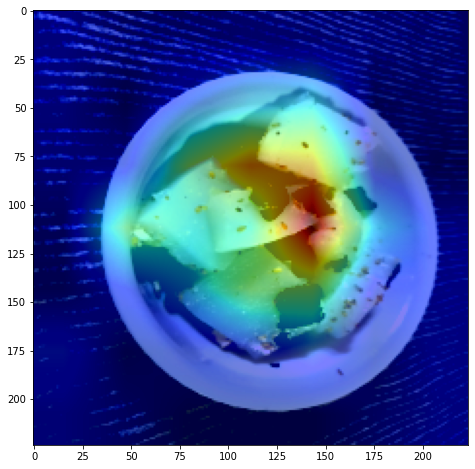

In [9]:
vis_gradcam(model, data)

In [30]:
model.model._blocks[-1]

MBConvBlock(
  (_expand_conv): Conv2dStaticSamePadding(
    192, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn0): BatchNorm2d(1152, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_depthwise_conv): Conv2dStaticSamePadding(
    1152, 1152, kernel_size=(3, 3), stride=[1, 1], groups=1152, bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn1): BatchNorm2d(1152, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_se_reduce): Conv2dStaticSamePadding(
    1152, 48, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_se_expand): Conv2dStaticSamePadding(
    48, 1152, kernel_size=(1, 1), stride=(1, 1)
    (static_padding): Identity()
  )
  (_project_conv): Conv2dStaticSamePadding(
    1152, 320, kernel_size=(1, 1), stride=(1, 1), bias=False
    (static_padding): Identity()
  )
  (_bn2): BatchNorm2d(320, eps=0.001, moment